In [31]:
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import chardet

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from pathlib import Path
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [2]:
#Price Datamining

driver = webdriver.Chrome()
url='https://zhangjiakou.esf.fang.com/house-a011426/'
driver.get(url)
table = driver.find_element(By.CSS_SELECTOR, "div.shop_list.shop_list_4")
table.text

# defining functions to transfer chinese to numbers
def _parse_area(s):
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:㎡|平米|m²)', s or "")
    return float(m.group(1)) if m else None

def _parse_price_yuan(s):
    s = (s or "").strip()
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*万', s)
    return float(m.group(1)) * 10000 if m else None

# defining function to get data of current page
def get_current_page_data():
    data = []
    table = driver.find_element(By.CSS_SELECTOR, "div.shop_list.shop_list_4")
    rows  = table.find_elements(By.TAG_NAME, 'dl')

    for row in rows:
        try:
            # ---- area：<p class="tel_shop"> ----
            tel_text = ""
            for dd in row.find_elements(By.TAG_NAME, "dd"):
                try:
                    p = dd.find_element(By.CSS_SELECTOR, "p.tel_shop")
                    tel_text = p.get_attribute("textContent").strip()
                    break
                except NoSuchElementException:
                    continue
            area_m2 = _parse_area(tel_text)

            # ---- price：<dd class="price_right"> -> <span class="red"> ----
            price_yuan = None
            for dd in row.find_elements(By.TAG_NAME, "dd"):
                cls = (dd.get_attribute("class") or "")
                if "price_right" in cls:
                    try:
                        red = dd.find_element(By.CSS_SELECTOR, "span.red")
                        red_txt = (red.get_attribute("textContent") or "").strip()
                    except NoSuchElementException:
                        red_txt = (dd.get_attribute("textContent") or "").strip()
                    price_yuan = _parse_price_yuan(red_txt)
                    break

            if area_m2 is not None and price_yuan is not None:
                data.append([area_m2, price_yuan])

        except Exception:
            continue

    return data

driver.get(url)
all_data = []
i = 0
Num_Pages = 3

while i < Num_Pages:
    all_data.extend(get_current_page_data())
    
    if i == Num_Pages:
        break 
        
    try:
        # find href of next page
        next_page = WebDriverWait(driver, 8).until(
            EC.element_to_be_clickable((By.XPATH, "//div[@class='page_al']//a[contains(text(),'下一页')]"))
        )
        href = next_page.get_attribute("href")
        if not href:
            print("未找到下一页链接，结束。")
            break

        driver.get(href)

        # wait until the next page shows up
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.shop_list.shop_list_4"))
        )
        time.sleep(1.0)

        i += 1
    except (NoSuchElementException, TimeoutException):
        print("已到最后一页或翻页失败。")
        break

print(f"共抓取 {len(all_data)} 条记录。前几条示例：")
for r in all_data[:5]:
    print(r)
    
df = pd.DataFrame(all_data, columns=["area_m2", "price_yuan"])
df["location"] = "张北"
df["price_per_m2"] = df["price_yuan"] / df["area_m2"]
csv_filename = "price_zhangbei_data.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8-sig")
print(f"数据已保存到 {csv_filename}")

driver.quit()

已到最后一页或翻页失败。
共抓取 164 条记录。前几条示例：
[98.0, 380000.0]
[90.65, 430000.0]
[95.28, 450000.0]
[109.0, 280000.0]
[120.0, 480000.0]
数据已保存到 price_zhangbei_data.csv


In [9]:
# Rent Datamining 

driver = webdriver.Chrome()
url='https://zhangjiakou.zu.fang.com/house-a011426/'
driver.get(url)
table = driver.find_element(By.CSS_SELECTOR, "div.houseList")
table.text

# defining functions to transfer chinese to numbers
def _parse_area(s):
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:㎡|平米|m²)', s or "")
    return float(m.group(1)) if m else None

def _parse_rent_yuan(s: str):
    s = (s or "").strip()
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*元\s*/\s*月', s)
    if m:
        return float(m.group(1))
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)$', s)
    if m:
        return float(m.group(1))
    return None

# defining function to get data of current page
def get_current_page_data():
    data = []
    table = driver.find_element(By.CSS_SELECTOR, "div.houseList")
    rows  = table.find_elements(By.TAG_NAME, 'dl')

    for row in rows:
        try:
            # ---- area：<XPATH = .//p[contains(@class,'mt') and contains(.,'㎡')]> ----
            tel_text = ""
            for dd in row.find_elements(By.TAG_NAME, "dd"):
                try:
                    p = dd.find_element(
                        By.XPATH, ".//p[contains(@class,'mt') and contains(.,'㎡')]"
                    )
                    tel_text = p.get_attribute("textContent").strip()
                    break
                except NoSuchElementException:
                    continue
            area_m2 = _parse_area(tel_text)

            # ---- rent：<span class="price"> ----
            rent_yuan = None   
            try:
                span_price = row.find_element(By.CSS_SELECTOR, "span.price")
                # 优先 textContent，确保拿到纯数字
                price_txt = (span_price.get_attribute("textContent") or span_price.text).strip()
                # 也可以拼接父节点文本以防个别页面只给出“元/月”在外层
                dd_text = row.get_attribute("textContent")
                # 解析为 元/月
                rent_yuan = _parse_rent_yuan(price_txt) or _parse_rent_yuan(dd_text)
            except NoSuchElementException:
                rent_yuan = None

            if area_m2 is not None and rent_yuan is not None:
                data.append([area_m2, rent_yuan])

        except Exception:
            continue

    return data

driver.get(url)
all_data = []
i = 1
Num_Pages = 2

while i <= Num_Pages:
    all_data.extend(get_current_page_data())
    
    if i == Num_Pages:
        break 
        
    try:
        # find href of next page
        next_page = WebDriverWait(driver, 8).until(
            EC.element_to_be_clickable((By.XPATH, "/html/body/div[4]/div[4]/div[1]/div[6]/a[4]"))
        )
        href = next_page.get_attribute("href")
        if not href:
            print("未找到下一页链接，结束。")
            break

        driver.get(href)

        # wait until the next page shows up
        WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "div.houseList"))
        )
        time.sleep(1.0) 

        i += 1 
    except (NoSuchElementException, TimeoutException):
        print("已到最后一页或翻页失败。")
        break

print(f"共抓取 {len(all_data)} 条记录。前几条示例：")
for r in all_data[:5]:
    print(r)
    
df = pd.DataFrame(all_data, columns=["area_m2", "rent_yuan"])  
df["location"] = "张北"
df["rent_per_m2"] = df["rent_yuan"] / df["area_m2"]
csv_filename = "rent_zhangbei_data.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8-sig")

print(f"数据已保存到 {csv_filename}")

driver.quit()

共抓取 75 条记录。前几条示例：
[93.0, 1100.0]
[93.0, 1100.0]
[82.0, 850.0]
[96.0, 1200.0]
[88.0, 833.0]
数据已保存到 rent_zhangbei_data.csv


In [5]:
files = [
    ("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/xiahuayuan_housing_price.csv",
     "/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price/xiahuayuan_housing_price_utf8.csv"),
    
    ("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/xiahuayuan_rent_price.csv",
     "/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent/xiahuayuan_rent_price_utf8.csv")
]

for input_file, output_file in files:
    with open(input_file, "rb") as f:
        raw = f.read(50000)
        result = chardet.detect(raw)
    enc = result["encoding"]
    print(f"检测到文件 {input_file} 编码为：{enc}")

    try:
        df = pd.read_csv(input_file, encoding=enc, low_memory=False)
        print("✅ 成功读取文件")
    except Exception as e:
        print(f"⚠️ 使用 {enc} 编码读取失败，尝试使用 gbk ...")
        df = pd.read_csv(input_file, encoding="gbk", low_memory=False)
        
    df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"✅ 已转换为 UTF-8 编码，保存为：{output_file}\n")

检测到文件 /Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/xiahuayuan_housing_price.csv 编码为：utf-8
✅ 成功读取文件
✅ 已转换为 UTF-8 编码，保存为：/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price/xiahuayuan_housing_price_utf8.csv

检测到文件 /Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/xiahuayuan_rent_price.csv 编码为：GB2312
⚠️ 使用 GB2312 编码读取失败，尝试使用 gbk ...
✅ 已转换为 UTF-8 编码，保存为：/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent/xiahuayuan_rent_price_utf8.csv



In [11]:
# 数据清洗

# 配置：输入/输出目录
folder1_in  = Path("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price")      # 售房CSV所在目录
folder1_out = Path("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_out")
folder2_in  = Path("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent")       # 租房CSV所在目录
folder2_out = Path("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent_out")
folder1_out.mkdir(exist_ok=True)
folder2_out.mkdir(exist_ok=True)

def process_dir(in_dir: Path, out_dir: Path, rename_map: dict,
                value_col: str, per_m2_col: str, pattern: str="*.csv"):
    """
    - rename_map: 列重命名映射，如 {"price":"price_yuan"} 或 {"price":"rent_yuan","price_per_m2":"rent_per_m2"}
    - value_col: 价格列名（售房用 "price_yuan"，租房用 "rent_yuan"）
    - per_m2_col: 单价列名（售房 "price_per_m2"，租房 "rent_per_m2"）
    """
    # 提取数字的辅助函数
    def _extract_number(cell):
        if pd.isna(cell):
            return pd.NA
        s = str(cell).replace(",", "")  # 去千分位逗号
        m = re.search(r'[-+]?\d+(?:\.\d+)?', s)  # 抓第一个整数或小数
        return float(m.group(0)) if m else pd.NA

    for f in sorted(in_dir.glob(pattern)):
        try:
            df = pd.read_csv(f, encoding="utf-8-sig")

            # 重命名
            df = df.rename(columns=rename_map)

            # 对关键数值列先“提取数字”
            target_cols = [c for c in ["area_m2", value_col, per_m2_col] if c in df.columns]
            for c in target_cols:
                df[c] = df[c].apply(_extract_number)

            # 若是文件夹1，price列 *10000
            if in_dir.name.lower().startswith("price") and value_col in df.columns:
                if f.name != "price_zhangbei_data.csv":
                    df[value_col] = df[value_col] * 10000

            # 删除关键列缺失行
            key_cols = [c for c in ["area_m2", value_col, per_m2_col] if c in df.columns]
            for c in key_cols:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            if key_cols:
                df = df.dropna(subset=key_cols)

            # 数值保留位数
            if "area_m2" in df.columns:
                df["area_m2"] = df["area_m2"].round(0).astype("Int64")
            if value_col in df.columns:
                df[value_col] = df[value_col].round(0).astype("Int64")
            if per_m2_col in df.columns:
                df[per_m2_col] = df[per_m2_col].round(0).astype("Int64")

            # 调整列顺序：把 location 移到第 3 列
            if "location" in df.columns:
                cols = list(df.columns)
                cols.remove("location")
                cols.insert(2, "location")
                df = df[cols]

            # 保存
            out_file = out_dir / f"{f.stem}_clean.csv"
            df.to_csv(out_file, index=False, encoding="utf-8-sig")
            print(f" {f.name} -> {out_file.name}（{len(df)} 行）")
        except Exception as e:
            print(f" 处理失败 {f.name}: {e}")
            
# 执行：分别处理两个目录
# 文件夹一：m2 -> area_m2, price -> price_yuan
process_dir(folder1_in, folder1_out,
            rename_map={"price": "price_yuan", "m2": "area_m2"},
            value_col="price_yuan",
            per_m2_col="price_per_m2")

# 文件夹二：m2 -> area_m2, price -> rent_yuan，price_per_m2 -> rent_per_m2
process_dir(folder2_in, folder2_out,
            rename_map={"price": "rent_yuan", "price_per_m2": "rent_per_m2", "m2": "area_m2"},
            value_col="rent_yuan",
            per_m2_col="rent_per_m2")

 huailai_housing_price.csv -> huailai_housing_price_clean.csv（2600 行）
 price_zhangbei_data.csv -> price_zhangbei_data_clean.csv（164 行）
 qiaoxi_housing_price.csv -> qiaoxi_housing_price_clean.csv（1728 行）
 xiahuayuan_housing_price_utf8.csv -> xiahuayuan_housing_price_utf8_clean.csv（448 行）
 huailai_rent_price.csv -> huailai_rent_price_clean.csv（78 行）
 qiaoxi_rent_price.csv -> qiaoxi_rent_price_clean.csv（78 行）
 rent_zhangbei_data.csv -> rent_zhangbei_data_clean.csv（75 行）
 xiahuayuan_rent_price_utf8.csv -> xiahuayuan_rent_price_utf8_clean.csv（175 行）


In [12]:
# 合并数据
def merge_csvs(in_dir: Path, out_path: Path):
    """将一个文件夹下的所有 csv 合并成一个"""
    csv_files = sorted(in_dir.glob("*.csv"))

    dfs = []
    for f in csv_files:
        try:
            df = pd.read_csv(f, encoding="utf-8-sig")
            dfs.append(df)
            print(f"读取 {f.name}（{len(df)} 行）")
        except Exception as e:
            print(f"读取失败 {f.name}: {e}")

    if dfs:
        merged = pd.concat(dfs, ignore_index=True)
        merged.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"合并完成：{out_path.name}（共 {len(merged)} 行）\n")
    else:
        print(f"{in_dir} 无有效数据。")


# ===== 分别执行合并 =====
price_out_dir = Path("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_out")
rent_out_dir  = Path("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent_out")

merge_csvs(price_out_dir, price_out_dir / "merged_price.csv")
merge_csvs(rent_out_dir, rent_out_dir  / "merged_rent.csv")

读取 huailai_housing_price_clean.csv（2600 行）
读取 price_zhangbei_data_clean.csv（164 行）
读取 qiaoxi_housing_price_clean.csv（1728 行）
读取 xiahuayuan_housing_price_utf8_clean.csv（448 行）
合并完成：merged_price.csv（共 4940 行）

读取 huailai_rent_price_clean.csv（78 行）
读取 qiaoxi_rent_price_clean.csv（78 行）
读取 rent_zhangbei_data_clean.csv（75 行）
读取 xiahuayuan_rent_price_utf8_clean.csv（175 行）
合并完成：merged_rent.csv（共 406 行）



In [16]:
# 描述性统计

# 二手房
df = pd.read_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_out/merged_price.csv")

# 查看基本信息
print(df.info())

# 对关键列进行描述性统计
print(df[["area_m2", "price_yuan", "price_per_m2"]].describe())

# 定义IQR剔除异常值函数
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        if col not in df_clean.columns:
            continue
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# 对面积、价格、单价剔除异常值
clean_df = remove_outliers_iqr(df, ["area_m2", "price_yuan", "price_per_m2"])

print(f"原始数据 {len(df)} 条，剔除后 {len(clean_df)} 条")

# 保存结果
out_path = "/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_out/merged_price_cleaned.csv"
clean_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"已保存剔除异常值后的数据：{out_path}")

# 租房
df = pd.read_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent_out/merged_rent.csv")

# 查看基本信息
print(df.info())

# 对关键列进行描述性统计
print(df[["area_m2", "rent_yuan", "rent_per_m2"]].describe())

# 定义IQR剔除异常值函数
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        if col not in df_clean.columns:
            continue
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# 对面积、价格、单价剔除异常值
clean_df = remove_outliers_iqr(df, ["area_m2", "rent_yuan", "rent_per_m2"])

print(f"原始数据 {len(df)} 条，剔除后 {len(clean_df)} 条")

# 保存结果
out_path = "/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent_out/merged_rent_cleaned.csv"
clean_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"已保存剔除异常值后的数据：{out_path}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4940 entries, 0 to 4939
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   area_m2       4940 non-null   int64 
 1   price_yuan    4940 non-null   int64 
 2   location      4940 non-null   object
 3   price_per_m2  4940 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 154.5+ KB
None
           area_m2    price_yuan  price_per_m2
count  4940.000000  4.940000e+03   4940.000000
mean    106.884008  7.929223e+05   6519.245344
std      63.410288  9.505889e+05   3651.894805
min      21.000000  6.500000e+04    913.000000
25%      76.000000  3.300000e+05   4181.000000
50%      91.000000  4.900000e+05   5599.500000
75%     121.000000  7.992500e+05   7693.000000
max     800.000000  1.500000e+07  36505.000000
原始数据 4940 条，剔除后 4125 条
已保存剔除异常值后的数据：/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_out/merged_price_cleaned.csv
<class 'pandas.core.frame.DataFrame'>
R

各街区中位数价格-租金比：
          median_price_per_m2  median_rent_per_m2  price_to_rent_ratio
location                                                              
下花园                    3409.0                11.0           309.909091
张北                     4062.0                11.0           369.272727
怀来                     5290.0                15.0           352.666667
桥西                     5557.5                15.0           370.500000


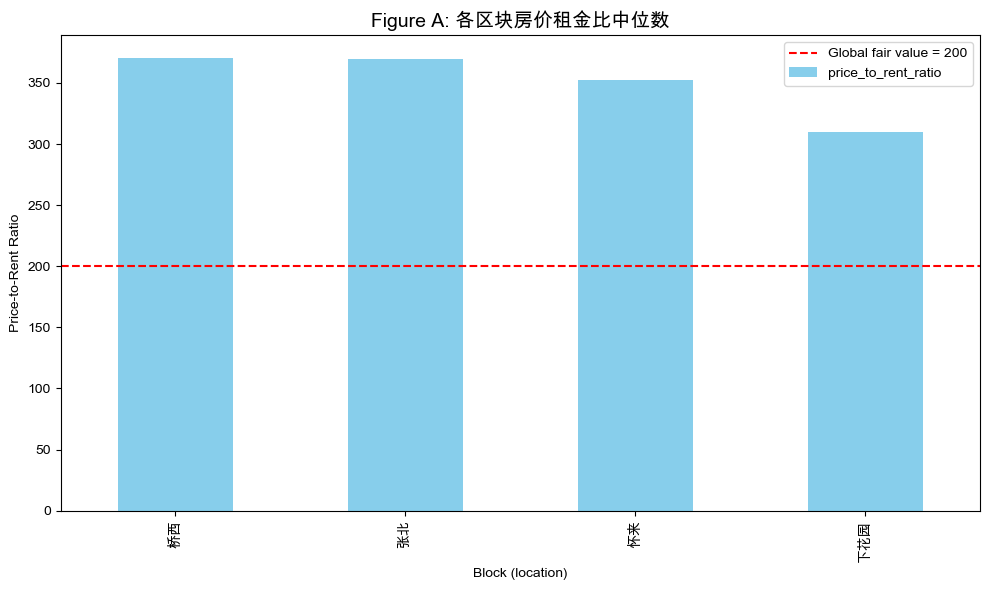

In [19]:
# 计算各区块的房价租金比并绘制Figure A
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 加载清洗后数据
price_df = pd.read_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model//Price_out/merged_price_cleaned.csv")
rent_df  = pd.read_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent_out/merged_rent_cleaned.csv")

# 确保关键列存在
for df in [price_df, rent_df]:
    for col in ["location", "area_m2"]:
        if col not in df.columns:
            raise ValueError(f"Missing key column {col}")

# 按 location取中位数
price_median = price_df.groupby("location")["price_per_m2"].median().rename("median_price_per_m2")
rent_median  = rent_df.groupby("location")["rent_per_m2"].median().rename("median_rent_per_m2")

# 合并两个表
merged = pd.concat([price_median, rent_median], axis=1).dropna()

# 计算 median Price-to-Rent Ratio 
merged["price_to_rent_ratio"] = merged["median_price_per_m2"] / merged["median_rent_per_m2"]

print("各街区中位数价格-租金比：")
print(merged)

# 绘制 Figure A
plt.figure(figsize=(10,6))
merged["price_to_rent_ratio"].sort_values(ascending=False).plot(kind="bar", color="skyblue")

plt.axhline(200, color="red", linestyle="--", label="Global fair value = 200")
plt.title("Figure A: 各区块房价租金比中位数", fontsize=14)
plt.ylabel("Price-to-Rent Ratio")
plt.xlabel("Block (location)")
plt.legend()
plt.tight_layout()
plt.show()

merged.to_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_Rent_Ratio_by_Block.csv",
              index=True, encoding="utf-8-sig")

Model 1  R²: 0.1423
Model 2  R²: 0.5063


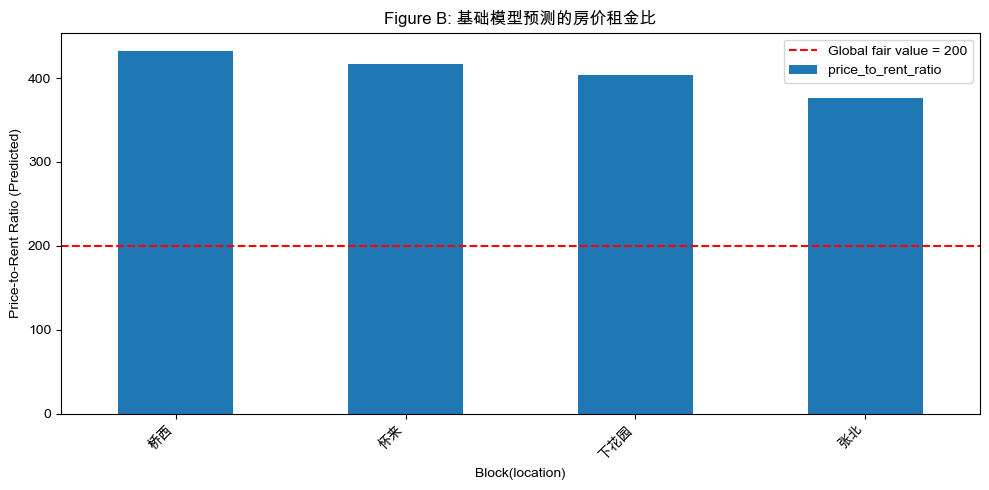

In [37]:
# 价格数据：建模 -> 逐条预测 -> 按 block 取“预测总价”的中位数
df_price = pd.read_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Price_out/merged_price_cleaned.csv")
X1 = pd.get_dummies(df_price[['area_m2', 'location']], drop_first=True)
y1 = df_price['price_per_m2']
model1 = LinearRegression().fit(X1, y1)
df_price['pred_price_per_m2'] = model1.predict(X1)
r2_model1 = model1.score(X1, y1)
print("Model 1  R²:", round(r2_model1, 4))

df_price['pred_price'] = df_price['pred_price_per_m2'] * df_price['area_m2']

price_block_median = (
    df_price.groupby('location', as_index=False)['pred_price']
            .median()
            .rename(columns={'pred_price': 'median_pred_price'})
)

# 租金数据：建模 -> 逐条预测 -> 按 block 取“预测总租”的中位数
df_rent = pd.read_csv("/Users/Peiyao_Jin/Desktop/Code/HW3_My_Data_My_Model/Rent_out/merged_rent_cleaned.csv")
X2 = pd.get_dummies(df_rent[['area_m2', 'location']], drop_first=True)
y2 = df_rent['rent_per_m2']
model2 = LinearRegression().fit(X2, y2)
df_rent['pred_rent_per_m2'] = model2.predict(X2)
r2_model2 = model2.score(X2, y2)
print("Model 2  R²:", round(r2_model2, 4))

df_rent['pred_rent'] = df_rent['pred_rent_per_m2'] * df_rent['area_m2']

rent_block_median = (
    df_rent.groupby('location', as_index=False)['pred_rent']
           .median()
           .rename(columns={'pred_rent': 'median_pred_rent'})
)

# 合并数据
block_ratio = pd.merge(price_block_median, rent_block_median, on='location', how='inner')

# 计算每个 block 的 price_to_rent_ratio
block_ratio['price_to_rent_ratio'] = block_ratio['median_pred_price'] / block_ratio['median_pred_rent']

# 绘制Figure B
block_ratio_sorted = block_ratio.sort_values('price_to_rent_ratio', ascending=False).set_index('location')

plt.figure(figsize=(10,5))
block_ratio_sorted['price_to_rent_ratio'].plot(kind='bar')
plt.ylabel('Price-to-Rent Ratio (Predicted)')
plt.xlabel('Block(location)')
plt.axhline(200, color="red", linestyle="--", label="Global fair value = 200")
plt.title('Figure B: 基础模型预测的房价租金比')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Model 1+ R²: 0.1568
Model 2+ R²: 0.594

R² comparison:
Model 1  : 0.1423
Model 1+ : 0.1568
Model 2  : 0.5063
Model 2+ : 0.5940


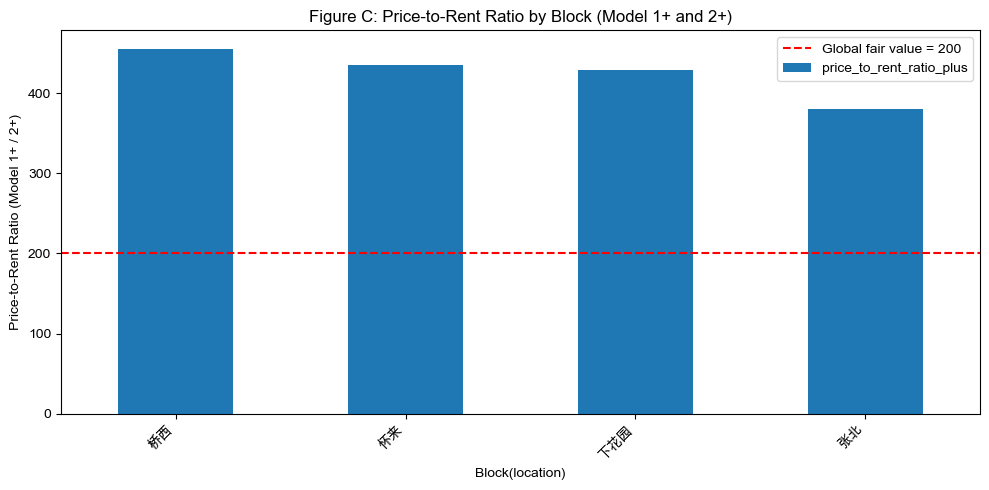

In [36]:
# 构建Model 1+ & Model 2+
poly = PolynomialFeatures(degree=2, include_bias=False)
X1_poly = poly.fit_transform(X1)
model1_plus = LinearRegression().fit(X1_poly, y1)
df_price['pred_price_per_m2_plus'] = model1_plus.predict(X1_poly)

r2_model1_plus = model1_plus.score(X1_poly, y1)
print("Model 1+ R²:", round(r2_model1_plus, 4))

X2_poly = poly.fit_transform(X2)
model2_plus = LinearRegression().fit(X2_poly, y2)
df_rent['pred_rent_per_m2_plus'] = model2_plus.predict(X2_poly)

r2_model2_plus = model2_plus.score(X2_poly, y2)
print("Model 2+ R²:", round(r2_model2_plus, 4))

print("\nR² comparison:")
print(f"Model 1  : {r2_model1:.4f}")
print(f"Model 1+ : {r2_model1_plus:.4f}")
print(f"Model 2  : {r2_model2:.4f}")
print(f"Model 2+ : {r2_model2_plus:.4f}")

# 使用 Model 1+ / Model 2+ 进行预测
df_price['pred_price_plus'] = df_price['pred_price_per_m2_plus'] * df_price['area_m2']
df_rent['pred_rent_plus']   = df_rent['pred_rent_per_m2_plus']   * df_rent['area_m2']

# 取中位数
price_block_median = (
    df_price.groupby('location', as_index=False)['pred_price_plus']
            .median()
            .rename(columns={'pred_price_plus': 'median_pred_price_plus'})
)
rent_block_median = (
    df_rent.groupby('location', as_index=False)['pred_rent_plus']
           .median()
           .rename(columns={'pred_rent_plus': 'median_pred_rent_plus'})
)

# 合并并计算 price-to-rent ratio
block_ratio_plus = pd.merge(price_block_median, rent_block_median, on='location', how='inner')
block_ratio_plus['price_to_rent_ratio_plus'] = block_ratio_plus['median_pred_price_plus'] / block_ratio_plus['median_pred_rent_plus']

# Figure C：按比值排序并画柱状图
block_ratio_sorted = block_ratio_plus.sort_values('price_to_rent_ratio_plus', ascending=False).set_index('location')

plt.figure(figsize=(10,5))
block_ratio_sorted['price_to_rent_ratio_plus'].plot(kind='bar')
plt.ylabel('Price-to-Rent Ratio (Model 1+ / 2+)')
plt.xlabel('Block(location)')
plt.axhline(200, color="red", linestyle="--", label="Global fair value = 200")
plt.title('Figure C: Price-to-Rent Ratio by Block (Model 1+ and 2+)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()